# Validation dataset for the Gnielinski correlation
Function: $\mathrm{Nu}(f,u,d,\nu,\kappa) = \frac{(f/8) \cdot (\frac{ud}{\nu} - 1000) \cdot (\frac{\nu}{\kappa})}{1 + 12.7 \cdot (f/8)^{1/2} \cdot \left(\left(\frac{\nu}{\kappa}\right)^{2/3} - 1 \right)}$

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from Regression.dataset import InvarianceDataset
from Regression.model import InvarianceModel
from Regression.detector import InvarianceDetector

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Reads the noisy dataset

In [2]:
xlsx_path = "../../Data/Gnielinski Noise.xlsx"
df = pd.read_excel(xlsx_path)

In [3]:
dataset = InvarianceDataset(df, "Nu")

In [4]:
# show a quick summary and the head of the dataframe
print("\nDataFrame summary (first 5 rows):\n")
print(dataset.head())

# show descriptive statistics
print("\nDescriptive statistics:\n")
print(dataset.summary())


DataFrame summary (first 5 rows):

          u         d             ν             κ         f          Nu
0  0.801540  0.012233  8.947896e-07  1.454717e-07  0.086776  160.278200
1  0.259575  0.078404  8.947896e-07  1.454717e-07  0.032685  173.340063
2  0.475659  0.042545  8.947896e-07  1.454717e-07  0.080124  275.291260
3  0.774637  0.063439  8.947896e-07  1.454717e-07  0.089813  784.600172
4  0.993837  0.043410  8.947896e-07  1.454717e-07  0.038795  481.262279

Descriptive statistics:

                 u            d             ν             κ            f  \
count  8000.000000  8000.000000  8.000000e+03  8.000000e+03  8000.000000   
mean      0.552120     0.054439  6.108286e-07  9.066672e-08     0.055316   
std       0.258749     0.026048  2.931597e-07  1.911857e-08     0.020151   
min       0.100287     0.010000  2.803664e-07  7.220751e-08     0.020013   
25%       0.331023     0.031602  3.917395e-07  7.708602e-08     0.038001   
50%       0.548265     0.054159  5.366270e-07  8.4

## DNN model

In [5]:
X_train, X_test, y_train, y_test = dataset.train_test_split()

In [6]:
# Initialize the DNN model
model = InvarianceModel(input_dim=5)

In [7]:
# Build and compile the DNN model
model.build_and_compile(X_train)

### Train the model if not saved already

In [ ]:
# Train the model
checkpoint_filepath = './tmp/checkpoint_gniel.weights.h5'
model_filepath = './tmp/checkpoint_gniel.keras'
model.train(X_train, y_train, checkpoint_path=checkpoint_filepath, model_path=model_filepath)

In [ ]:
# Save training history
history_filepath = './tmp/checkpoint_gniel.pkl'
model.save_history(history_filepath)

In [8]:
# Reload model and history
history_filepath = './tmp/checkpoint_gniel.pkl'
history = model.load_history(history_filepath)

model_filepath = './tmp/checkpoint_gniel.keras'
model.load_model(model_filepath)

### Model metrics

In [9]:
# Evaluate on test set
r2, mae, rmse = model.evaluate(X_test, y_test)

print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R² = 0.978
MAE = 57.935
RMSE = 95.316


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


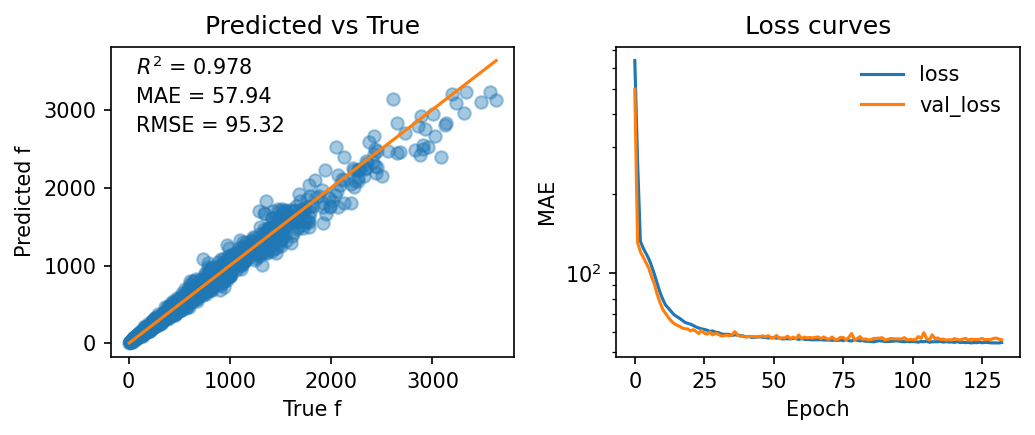

In [10]:
delta = max(y_test) - min(y_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), dpi=150)
test_predictions = model.predict(X_test)

# Scatter predicted vs true
ax1.scatter(y_test, test_predictions, alpha=0.4)
p1 = max(max(test_predictions), max(y_test))
p2 = min(min(test_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], "C1")
ax1.annotate(f"$R^2$ = {r2:.3f}", xy=(0.02 * delta, 0.95 * delta))
ax1.annotate(f"MAE = {mae:.2f}", xy=(0.02 * delta, 0.85 * delta))
ax1.annotate(f"RMSE = {rmse:.2f}", xy=(0.02 * delta, 0.75 * delta))
ax1.set_xlabel("True f")
ax1.set_ylabel("Predicted f")
ax1.set_title("Predicted vs True")

# Loss curves
ax2.plot(history['loss'], label='loss')
ax2.plot(history['val_loss'], label='val_loss')
ax2.set_yscale('log')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend(frameon=False)
ax2.set_title("Loss curves")

plt.tight_layout()
plt.show()

## Invariance detection
This section performs feature grouping analysis using combinations of two and three features.

The analysis aims to detect invariant groups of features in the form 
- $x_i^{\alpha_1} x_j^{\alpha_2}$ for pairs,
- $x_i^{\alpha_1} x_j^{\alpha_2} x_k^{\alpha_3}$ for triplets.

In [11]:
# Load the pre-trained model
model = InvarianceModel(input_dim=5)
model_filepath = './tmp/checkpoint_gniel.keras'
model.load_model(model_filepath)

In [12]:
# List of features
feature_names = dataset.feature_names
feature_names

['u', 'd', 'ν', 'κ', 'f']

### Initialize the Detector

In [13]:
detector = InvarianceDetector()

### Look for pairs

In [14]:
pairs = detector.find_invariant_pairs(dataset, model, [0.5, -0.5])

100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


In [15]:
print(pairs)

  feature_pair    mean_a     std_a    mean_b     std_b
0       (u, d) -0.715933  0.090749 -0.685203  0.098494
1       (u, ν)  0.816673  0.027560 -0.575067  0.039793
2       (u, κ)  0.945925  0.009896 -0.322977  0.028545
3       (u, f) -0.863533  0.066348 -0.485771  0.118049
4       (d, ν)  0.832688  0.026883 -0.551501  0.041882
5       (d, κ)  0.945666  0.014827 -0.321973  0.042761
6       (d, f)  0.885872  0.042493  0.455333  0.078077
7       (ν, κ) -0.891528  0.022624 -0.450247  0.044088
8       (ν, f)  0.756262  0.046882 -0.650351  0.053985
9       (κ, f)  0.513816  0.048383 -0.856003  0.030170


### Look for coupled pairs

In [16]:
coupled_pairs = detector.find_invariant_coupled_pairs(dataset, model, [0.5, -0.5, 0.5, -0.5])

100%|██████████| 30/30 [04:51<00:00,  9.71s/it]


In [17]:
print(coupled_pairs)

        coupled_pair    mean_a     std_a    mean_b     std_b    mean_c  \
0   ((u, d), (u, ν))  0.189386  0.013115 -0.981812  0.002569  0.864618   
1   ((u, d), (u, κ))  0.024237  0.011328 -0.999642  0.000269  0.951372   
2   ((u, d), (u, f)) -0.634570  0.101508 -0.760516  0.092910 -0.228624   
3   ((u, d), (d, ν))  0.544116  0.007377 -0.838964  0.004732  0.964551   
4   ((u, d), (d, κ)) -0.134323  0.085447 -0.987205  0.009131  0.901062   
5   ((u, d), (d, f)) -0.552877  0.109760 -0.822276  0.078376  0.583749   
6   ((u, ν), (u, κ))  0.682147  0.052003 -0.727734  0.048740  0.704400   
7   ((u, ν), (u, f))  0.866368  0.016917 -0.498243  0.029547  0.416266   
8   [(u, ν), (ν, d)]  0.770452  0.034013 -0.635190  0.042191 -0.064451   
9   ((u, ν), (ν, κ))  0.681329  0.024621 -0.731217  0.022523  0.694651   
10  ((u, ν), (ν, f))  0.884527  0.036781 -0.459037  0.074454  0.204432   
11  ((u, κ), (u, f))  0.954171  0.019902 -0.290992  0.066974  0.191816   
12  [(u, κ), (κ, d)]  0.620237  0.0020